In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, classification_report, RocCurveDisplay, make_scorer

## Load prepared data

In [2]:
tvec_df = pd.read_csv('../data/tvec_lemmatized_1000.csv')
tvec_df.shape

(3657, 2001)

In [3]:
# Remove intersected words from misprediction classes (have to run coef part first)
# try:
#     tvec_df = tvec_df[[col for col in tvec_df.columns if col not in words_to_remove]]
# except:
#     print('No words to be removed (not run to the end yet)')
# tvec_df.shape

In [4]:
# Filter out some classes
# Video, Picture can be detect from the attached link or uploaded video/image
# Meme / Shitpost, Hot Wasabi and Meta will not be suggested as these are tags with no specific topic
# tvec_df_filtered = tvec_df[(tvec_df['tag'] != 'Video') & (tvec_df['tag'] != 'Picture') & (tvec_df['tag'] != 'Meme / Shitpost') & (tvec_df['tag'] != 'Hot Wasabi') & (tvec_df['tag'] != 'Meta')]
# tvec_df_filtered['tag'].unique()

In [5]:
# Filter out some classes
# Video, Picture can be detect from the attached link or uploaded video/image
tvec_df_filtered = tvec_df[(tvec_df['tag'] != 'Video') & (tvec_df['tag'] != 'Picture')]
tvec_df_filtered['tag'].unique()

array(['Discussion', 'Question', 'Meme / Shitpost', 'News', 'Guide',
       'Tech Support', 'Feature Request', 'Configuration', 'MEGATHREAD',
       'Meta', 'Hot Wasabi'], dtype=object)

In [6]:
# Engineer more feature, count_words
# tvec_df_filtered['count_words'] = tvec_df_filtered.apply(lambda row: (row != 0).sum(), axis=1)

## Do more EDA on vectorized data

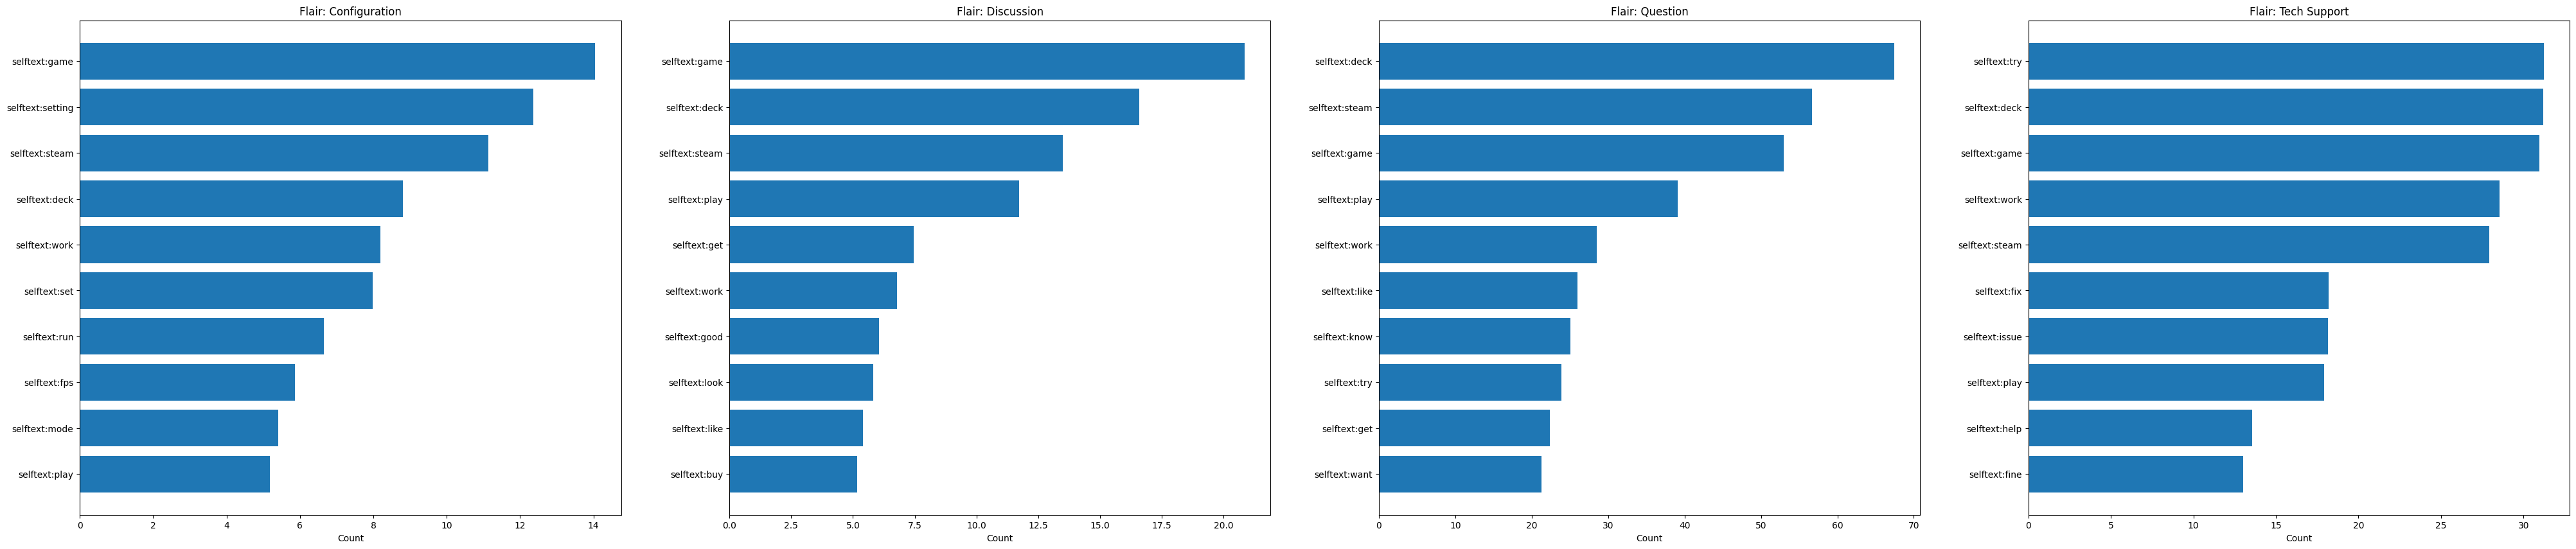

In [44]:
# Top common words (selftext) - tried removing some of these and found that it has no significant effect on models or making it worse
# No count_words
plt.figure(figsize=(50, 10))

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Configuration'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 1)
plt.barh(label, plot_data)
plt.title('Flair: Configuration')
plt.xlabel('Count');

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Discussion'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 2)
plt.barh(label, plot_data)
plt.title('Flair: Discussion')
plt.xlabel('Count');

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Question'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 3)
plt.barh(label, plot_data)
plt.title('Flair: Question')
plt.xlabel('Count');

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Tech Support'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 4)
plt.barh(label, plot_data)
plt.title('Flair: Tech Support')
plt.xlabel('Count');

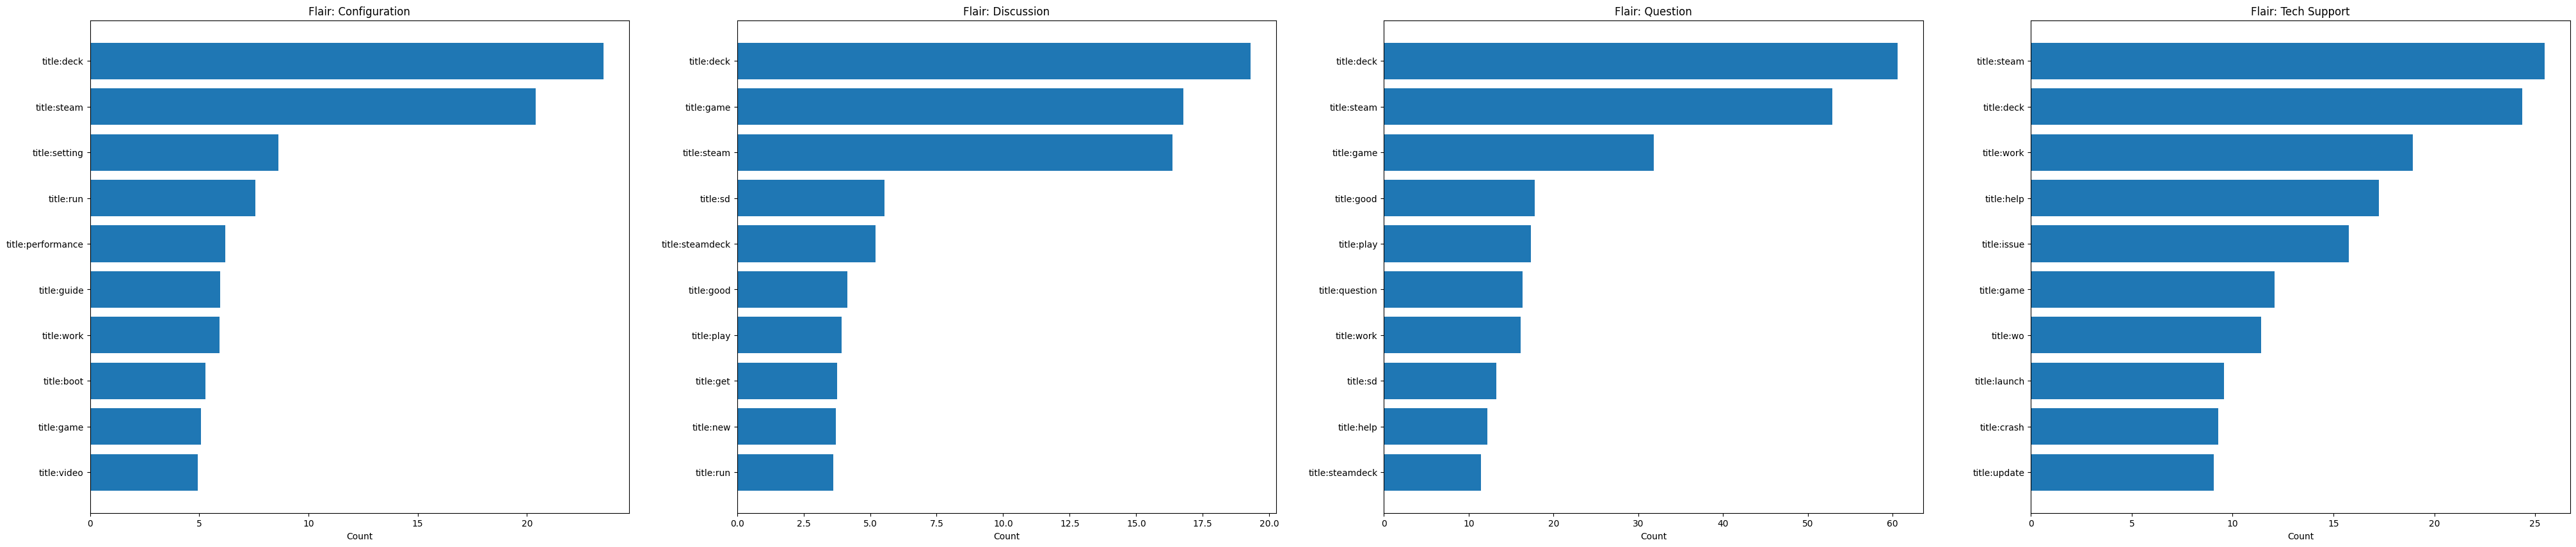

In [45]:
# Top common words (title) - tried removing some of these and found that it has no significant effect on models or making it worse
# No count_words
plt.figure(figsize=(50, 10))

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Configuration'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 1)
plt.barh(label, plot_data)
plt.title('Flair: Configuration')
plt.xlabel('Count');

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Discussion'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 2)
plt.barh(label, plot_data)
plt.title('Flair: Discussion')
plt.xlabel('Count');

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Question'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 3)
plt.barh(label, plot_data)
plt.title('Flair: Question')
plt.xlabel('Count');

plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Tech Support'].drop(columns='tag')
plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
plt.subplot(1, 4, 4)
plt.barh(label, plot_data)
plt.title('Flair: Tech Support')
plt.xlabel('Count');

In [8]:
# Top common words (selftext) - tried removing some of these and found that it has no significant effect on models or making it worse
# With count_words
# plt.figure(figsize=(50, 10))

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Configuration'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 1)
# plt.barh(label, plot_data)
# plt.title('Flair: Configuration')
# plt.xlabel('Count');

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Discussion'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 2)
# plt.barh(label, plot_data)
# plt.title('Flair: Discussion')
# plt.xlabel('Count');

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Question'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 3)
# plt.barh(label, plot_data)
# plt.title('Flair: Question')
# plt.xlabel('Count');

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Tech Support'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^selftext').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 4)
# plt.barh(label, plot_data)
# plt.title('Flair: Tech Support')
# plt.xlabel('Count');

In [ ]:
# Top common words (title) - tried removing some of these and found that it has no significant effect on models or making it worse
# With count_words
# plt.figure(figsize=(50, 10))

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Configuration'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 1)
# plt.barh(label, plot_data)
# plt.title('Flair: Configuration')
# plt.xlabel('Count');

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Discussion'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 2)
# plt.barh(label, plot_data)
# plt.title('Flair: Discussion')
# plt.xlabel('Count');

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Question'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 3)
# plt.barh(label, plot_data)
# plt.title('Flair: Question')
# plt.xlabel('Count');

# plot_data = tvec_df_filtered[tvec_df_filtered['tag'] == 'Tech Support'].drop(columns=['tag', 'count_words'])
# plot_data = plot_data.filter(regex=r'^title').sum().sort_values(ascending=False)[:10].sort_values(ascending=True)
# label = [re.sub(r'_vec__', ':', row) for row in plot_data.index]
# plt.subplot(1, 4, 4)
# plt.barh(label, plot_data)
# plt.title('Flair: Tech Support')
# plt.xlabel('Count');

## Create X, y

In [9]:
X_tvec = tvec_df.drop(columns=['tag'])
y_tvec = tvec_df['tag']

X_tvec_filtered = tvec_df_filtered.drop(columns=['tag'])
y_tvec_filtered = tvec_df_filtered['tag']

In [10]:
# Scale, for count_words
# ss = StandardScaler()
# X_tvec = ss.fit_transform(X_tvec)
# X_tvec_filtered = ss.fit_transform(X_tvec_filtered)

## Selected Model Optimization

In [11]:
# Prepare function for training + evaluation
def grid_train_and_evaluate(X, y, est, grid_params):
    
    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    # Setup gridsearch
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model_gs = GridSearchCV(
        est,
        grid_params,
        cv=cv,
        scoring='f1_micro', # Class imbalance
        verbose=1
    )

    # Train and Predict
    model_gs.fit(X_train, y_train)
    y_train_pred = model_gs.predict(X_train)
    y_test_pred = model_gs.predict(X_test)
    class_name = model_gs.best_estimator_.classes_ # name of labels
    
    # Display train, test portion and score
    print('Train:', X_train.shape)
    print('Test:', X_test.shape)
    print('F1 Micro Train:', f1_score(y_train, y_train_pred, average='micro'))
    print('F1 Micro Test:', f1_score(y_test, y_test_pred, average='micro'))
    print(classification_report(y_test, y_test_pred))

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_name)
    disp.plot(xticks_rotation=75)

    return model_gs

### Model Testing

In [12]:
# Baseline
y_tvec_filtered.value_counts(normalize=True)

tag
Question           0.207313
Tech Support       0.130917
Meme / Shitpost    0.084884
News               0.084558
Guide              0.082599
MEGATHREAD         0.081946
Configuration      0.081293
Meta               0.079334
Feature Request    0.076069
Discussion         0.057134
Hot Wasabi         0.033954
Name: proportion, dtype: float64

In [13]:
# Initiate estimator (select one)
est = LogisticRegression(n_jobs=-1, max_iter=500)
# est = RandomForestClassifier(n_jobs=-1)
# est = MultinomialNB()

In [14]:
est.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [15]:
# Set gridsearch params (select one)

# For Lr
est_params = {
    # 'C': [0.001, 0.01, 0.1, 1]
    'C': [0.4]
}

# For Rf
# est_params = {
#     # 'min_samples_leaf': [1, 2, 3, 4, 5]
#     'min_samples_leaf': [1, 2, 3],
#     'max_depth': [100, 150, 200],
#     'ccp_alpha': [0, 0.001, 0.01, 0.1]
# }

# For NB
# est_params = {
#     'alpha': [0.001, 0.01, 0.1, 1]
# }

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Train: (2297, 2000)
Test: (766, 2000)
F1 Micro Train: 0.7361776229865041
F1 Micro Test: 0.5221932114882507
                 precision    recall  f1-score   support

  Configuration       0.47      0.29      0.36        62
     Discussion       0.00      0.00      0.00        44
Feature Request       0.82      0.57      0.67        58
          Guide       0.70      0.49      0.58        63
     Hot Wasabi       0.00      0.00      0.00        26
     MEGATHREAD       0.98      0.67      0.79        63
Meme / Shitpost       0.34      0.58      0.43        65
           Meta       0.29      0.25      0.27        61
           News       0.57      0.66      0.61        65
       Question       0.48      0.78      0.60       159
   Tech Support       0.54      0.56      0.55       100

       accuracy                           0.52       766
      macro avg       0.47      0.44      0.44       766
   weighted avg       0.51      0.52      0.50       766



C:\Users\icyge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\icyge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\icyge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

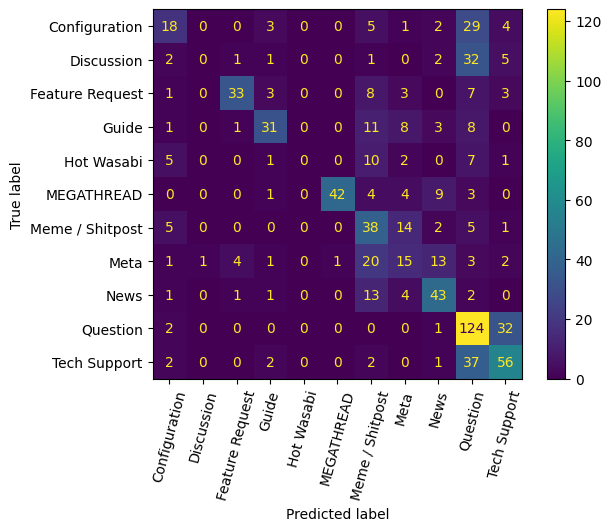

In [16]:
est_gs = grid_train_and_evaluate(X_tvec_filtered, y_tvec_filtered, est, est_params)

In [17]:
est_gs.best_params_

{'C': 0.4}

## Check Top coef words (only works with LogisticRegression)
** Output from this section is not used, due to words removal does not significantly affect model performance in a good way

In [18]:
# Printing top 20 words coef for each class label
coef_df = pd.DataFrame(est_gs.best_estimator_.coef_, index=est_gs.best_estimator_.classes_, columns=est_gs.feature_names_in_)
coef_df.columns = coef_df.columns

top_coef = {}
for class_name in coef_df.index:
    top_coef[class_name] = coef_df.loc[class_name].sort_values(ascending=False)[:100].index
    print(class_name)
    print(np.exp(coef_df.loc[class_name].sort_values(ascending=False))[:20])
    print('\n')

Configuration
selftext_vec__setting     4.662474
title_vec__deck           4.473791
title_vec__setting        3.052101
title_vec__theme          2.979093
selftext_vec__set         2.967038
title_vec__run            2.703382
title_vec__steam          2.434446
title_vec__setup          2.392143
title_vec__boot           2.248366
selftext_vec__enable      2.240003
title_vec__guide          2.238697
title_vec__performance    2.175544
selftext_vec__folder      2.087062
title_vec__video          2.078794
selftext_vec__mode        2.027375
title_vec__window         2.018521
title_vec__screen         2.008330
selftext_vec__user        1.942146
selftext_vec__device      1.886469
title_vec__tb             1.867441
Name: Configuration, dtype: float64


Discussion
selftext_vec__game          7.439527
title_vec__game             6.325395
selftext_vec__deck          5.191035
title_vec__deck             3.620501
selftext_vec__play          2.465918
selftext_vec__steam         2.430312
selftext_vec__g

In [19]:
# Check words intersection in the most misprediction classes
print(set(top_coef['News']) & set(top_coef['Guide']))
print(set(top_coef['News']) & set(top_coef['MEGATHREAD']))

set()
{'title_vec__dog', 'title_vec__die', 'title_vec__news', 'title_vec__official'}


In [20]:
# Prepare set of words to be removed
words_to_remove = \
    set(top_coef['News']) & set(top_coef['Guide']) |\
    set(top_coef['News']) & set(top_coef['MEGATHREAD'])
    # set(top_coef['Question']) & set(top_coef['Configuration']) |\
    # set(top_coef['Question']) & set(top_coef['Discussion']) |\
    # set(top_coef['Question']) & set(top_coef['Tech Support'])

In [21]:
len(words_to_remove)

4

** Process: after this section, goes back to the top to apply some changes on data and then testing the model again, continue this procedure until getting acceptable model

## Create custom prediction function with threshold to simulate tag suggestion

In [22]:
# Get prediction probabilities
X_train, X_test, y_train, y_test = train_test_split(X_tvec_filtered, y_tvec_filtered, random_state=42, stratify=y_tvec_filtered)

pred_proba = pd.DataFrame(est_gs.predict_proba(X_test), columns=est_gs.best_estimator_.classes_)
pred_proba.head()

,Configuration,Discussion,Feature Request,Guide,Hot Wasabi,MEGATHREAD,Meme / Shitpost,Meta,News,Question,Tech Support
0,0.086031,0.035992,0.061830,0.082152,0.043757,0.050235,0.165658,0.155249,0.118447,0.151809,0.048840
1,0.202652,0.038894,0.048282,0.036960,0.041934,0.041152,0.072971,0.056043,0.070779,0.120301,0.270032
2,0.105936,0.034573,0.088492,0.126752,0.038063,0.063374,0.141128,0.126654,0.128198,0.089305,0.057525
3,0.049610,0.064557,0.069369,0.050058,0.030819,0.034996,0.049292,0.046264,0.049702,0.352403,0.202931
4,0.146848,0.077429,0.025683,0.043757,0.016495,0.019622,0.024974,0.016081,0.018792,0.328308,0.282013


In [23]:
# Get the model accuracy
model_acc = est_gs.best_estimator_.score(X_test, y_test)
model_acc

0.5221932114882507

In [24]:
# Generate prediction with custom function, using threshold to be able to suggest multiple tags
def tag_suggestion(pred_proba, suggest_tags_num):
    predictions = []
    for row_num in pred_proba.index:
        row_proba = pred_proba.iloc[row_num].sort_values(ascending=False)

        # If max of prediction probability >= model performance + some margin (5%), suggest the best tag, else suggest top 3 tags instead
        if max(row_proba) >= (model_acc + 0.05):
            row_suggestion = list(row_proba.index[:1])
        else:
            row_suggestion = list(row_proba.index[:suggest_tags_num])

        predictions.append(row_suggestion)

    return predictions

In [25]:
predictions = tag_suggestion(pred_proba, 3)
predictions[:10]

[['Meme / Shitpost', 'Meta', 'Question'],
 ['Tech Support', 'Configuration', 'Question'],
 ['Meme / Shitpost', 'News', 'Guide'],
 ['Question', 'Tech Support', 'Feature Request'],
 ['Question', 'Tech Support', 'Configuration'],
 ['Question', 'Configuration', 'Tech Support'],
 ['Tech Support', 'Question', 'Discussion'],
 ['Question', 'Meme / Shitpost', 'Configuration'],
 ['Question', 'Discussion', 'Tech Support'],
 ['Guide', 'Feature Request', 'Configuration']]

In [26]:
# Compare with actual
for i in range(len(y_test)):
    print('Actual:', list(y_test)[i], '--- Suggest:', predictions[i])

Actual: Hot Wasabi --- Suggest: ['Meme / Shitpost', 'Meta', 'Question']
Actual: Hot Wasabi --- Suggest: ['Tech Support', 'Configuration', 'Question']
Actual: Guide --- Suggest: ['Meme / Shitpost', 'News', 'Guide']
Actual: Question --- Suggest: ['Question', 'Tech Support', 'Feature Request']
Actual: Guide --- Suggest: ['Question', 'Tech Support', 'Configuration']
Actual: Meme / Shitpost --- Suggest: ['Question', 'Configuration', 'Tech Support']
Actual: Tech Support --- Suggest: ['Tech Support', 'Question', 'Discussion']
Actual: Hot Wasabi --- Suggest: ['Question', 'Meme / Shitpost', 'Configuration']
Actual: Question --- Suggest: ['Question', 'Discussion', 'Tech Support']
Actual: Configuration --- Suggest: ['Guide', 'Feature Request', 'Configuration']
Actual: Feature Request --- Suggest: ['Feature Request', 'Meme / Shitpost', 'Meta']
Actual: MEGATHREAD --- Suggest: ['MEGATHREAD', 'Feature Request', 'Tech Support']
Actual: Question --- Suggest: ['Question', 'Discussion', 'Tech Support']
A

In [27]:
# Percentage of relevant suggestion
np.mean([list(y_test)[i] in predictions[i] for i in range(len(y_test))])

0.783289817232376